# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clustering

**Introduction: Classification *vs* Clustering**

In [2]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

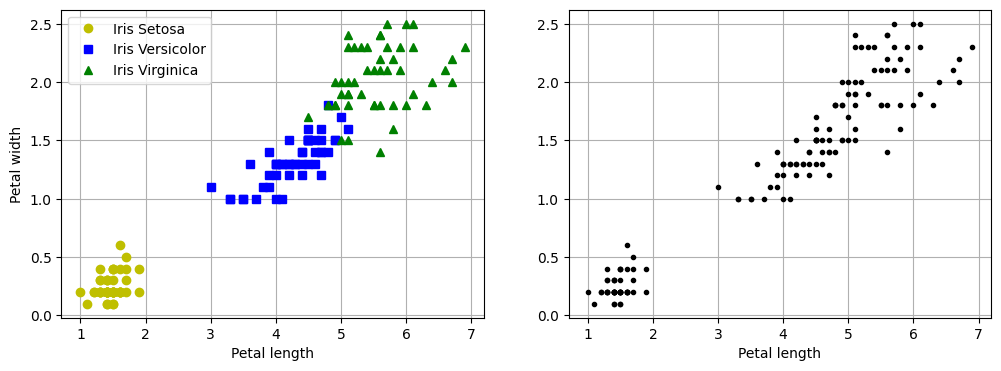

In [3]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(X[:, 2][y == 0], X[:, 3][y == 0], "yo", label="Iris Setosa")
plt.plot(X[:, 2][y == 1], X[:, 3][y == 1], "bs", label="Iris Versicolor")
plt.plot(X[:, 2][y == 2], X[:, 3][y == 2], "g^", label="Iris Virginica")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.grid()
plt.legend()

plt.subplot(122)
plt.plot(X[:, 2], X[:, 3], "k.")
plt.xlabel("Petal length")
plt.grid()

plt.show()

**Note:** The next code cell shows how a Gaussian Mixture model (explained later in this notebook) can actually these clusters quite well using all 4 features: petal length and width, sepal length and width.   

In [4]:
from sklearn.mixture import GaussianMixture

y_predict = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Next, we map each cluster to a class. Each cluster will have a unique id and here we try to map the cluster's id to the class in the dataset. Instead of hard coding the mapping, we will use `scipy.stats.mode()` function.

In [5]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_predict[y == class_id])
    mapping[mode] = class_id

Then we transform the predicted array to use the class in the dataset, instead of its self-created id, and plot the result.

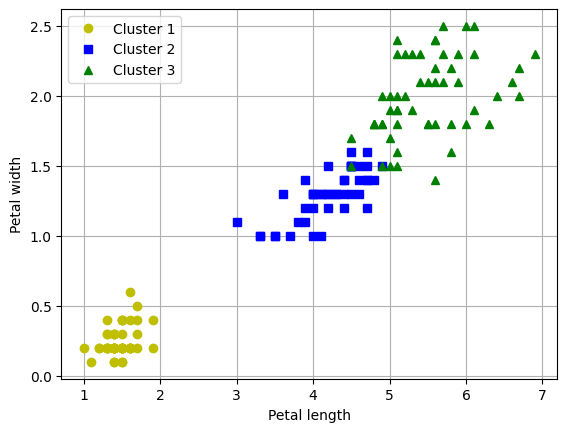

In [6]:
y_predict = np.array([mapping[cluster_id] for cluster_id in y_predict])

plt.plot(X[y_predict == 0, 2], X[y_predict == 0, 3], "yo", label="Cluster 1")
plt.plot(X[y_predict == 1, 2], X[y_predict == 1, 3], "bs", label="Cluster 2")
plt.plot(X[y_predict == 2, 2], X[y_predict == 2, 3], "g^", label="Cluster 3")
plt.grid()
plt.legend()
plt.xlabel("Petal length")
plt.ylabel("Petal width")

plt.show()

What's the ratio of iris plant we assigned to the right cluster?

In [7]:
(y_predict == y).sum() / len(y)

0.9666666666666667

And we only misclassify 5 of them.

In [8]:
len(y) - (y_predict == y).sum()

5

## K-means

**Fit and predict**

Here, we train a K-means clustering algorithm on a dataset of blobs. It will try to find the centroid of each blob and assign each instance to the closet blob.

In [9]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]]
)
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(
    n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7
)

Here, `random_state` is set to 1, to ensure that the centroids will be at the blob centers. The detail will be explained further as you go.

In [10]:
k = 5
k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
y_predict = k_means.fit_predict(X)

Then we will plot them.

In [11]:
def plot_cluster(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

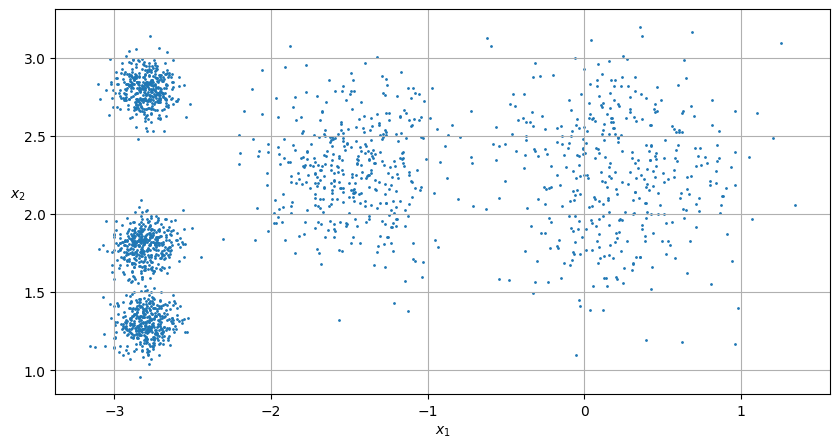

In [12]:
plt.figure(figsize=(10, 5))
plot_cluster(X)
plt.grid()

plt.show()

Each instance is assigned to one of the 5 clusters.

In [13]:
y_predict

array([1, 4, 0, ..., 3, 0, 4], dtype=int32)

In [14]:
y_predict is k_means.labels_

True

The following 5 centroids (i.e. cluster centers) were estimated as:  

In [15]:
k_means.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80389616,  1.80117999]])

Note that `KMeans` preserves the label of each instance it was trained on. This label is the index of the cluster it belongs to, not to be confused with the labels in the training set. 

In [16]:
k_means.labels_

array([1, 4, 0, ..., 3, 0, 4], dtype=int32)

Of course, we can predict the cluster new instances may belong to. 

In [17]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
k_means.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

**Decision boundaries**

In [18]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], "k.", markersize=2)

In [19]:
def plot_centroids(centroids, weights=None, circle_color="w", cross_color="k"):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="o",
        s=35,
        linewidths=8,
        color=circle_color,
        zorder=10,
        alpha=0.9,
    )
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=2,
        linewidths=12,
        color=cross_color,
        zorder=11,
        alpha=1,
    )

In [20]:
def plot_decision_boundaries(
    clusterer,
    X,
    resolution=1000,
    show_centroids=True,
    show_xlabels=True,
    show_ylabels=True,
):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(
        np.linspace(mins[0], maxs[0], resolution),
        np.linspace(mins[1], maxs[1], resolution),
    )
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(
        Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k"
    )
    plot_data(X)

    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)

    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

The result is a *Voronoi* diagram.

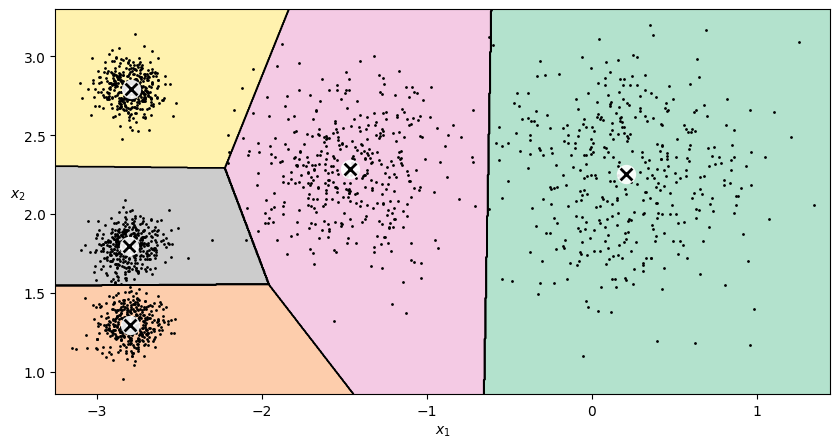

In [21]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(k_means, X)
plt.show()

Great! Some instances along the edge may be assigned to the wrong cluster, but in general, our model work very good.

**Hard Clustering vs Soft Clustering**

Rather than just assign an instance to the closest cluster, which is called *hard clustering*, it could be better to measure the distance to all 5 centroids. This is what the `transform()` method does.

In [22]:
k_means.transform(X_new).round(2)

array([[0.33, 2.89, 1.49, 2.9 , 2.81],
       [2.8 , 5.84, 4.48, 5.85, 5.81],
       [3.29, 1.71, 1.69, 0.29, 1.21],
       [3.22, 1.22, 1.55, 0.36, 0.73]])

You can check that this is in fact the Euclidean distance between each instance and each centroid.

In [23]:
np.linalg.norm(
    np.tile(X_new, (1, k)).reshape(-1, k, 2) - k_means.cluster_centers_, axis=2
).round(2)

array([[0.33, 2.89, 1.49, 2.9 , 2.81],
       [2.8 , 5.84, 4.48, 5.85, 5.81],
       [3.29, 1.71, 1.69, 0.29, 1.21],
       [3.22, 1.22, 1.55, 0.36, 0.73]])

### The K-Means algorithm

The K-means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
- First, initialize *k* centroids randomly. Which means select k distinct instances randomly from the dataset and places the centroids at their instances' locations.
- Repeat until converges (i.e. until the centroids stop moving):
    - Assign each instances to the closest centroid.
    - Update the centroids to be the mean of all the instances assigned to them.

The `KMeans` class uses an optimized initialization technique by default. To use the original K-Means algorithm (for educational purpose only, as it is subjectively worse than the default one), you must set `init=random` and `n_init=1`. More on that later on this chapter.

Here, we will run the K-means algorithm for 1, 2 and 3 iterations and see how the centroids move around.

In [24]:
k_means_iter1 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=1, random_state=1
)
k_means_iter2 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=2, random_state=1
)
k_means_iter3 = KMeans(
    n_clusters=5, init="random", n_init=1, max_iter=3, random_state=1
)
k_means_iter1.fit(X)
k_means_iter2.fit(X)
k_means_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=1)

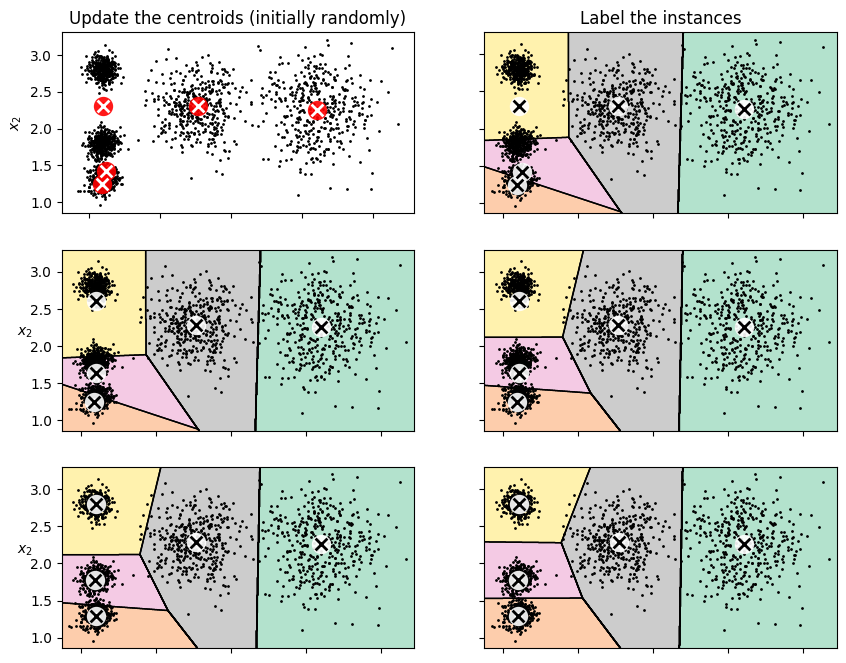

In [25]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(k_means_iter1.cluster_centers_, circle_color="r", cross_color="w")
plt.ylabel("$x_2$")
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(k_means_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(k_means_iter1, X, show_xlabels=False, show_centroids=False)
plot_centroids(k_means_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(k_means_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(k_means_iter2, X, show_xlabels=False, show_centroids=False)
plot_centroids(k_means_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(k_means_iter3, X, show_xlabels=False, show_ylabels=False)

There is one downside of the original K-means algorithm: If you run K-means multiple times (with different random seeds), each time the model can converge to different solution. That means the model could be a suboptimal solution.

In [26]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X)
    if title1:
        plt.title(title2)

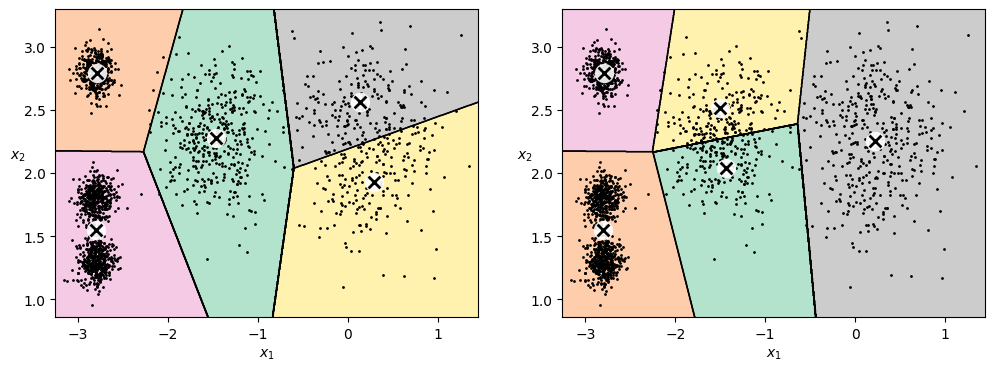

In [27]:
k_means_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
k_means_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=5)

plot_clusterer_comparison(k_means_rnd_init1, k_means_rnd_init2, X)
plt.show()

In [28]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
k_means = KMeans(n_clusters=5, n_init=1, init=good_init, random_state=42)
k_means.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

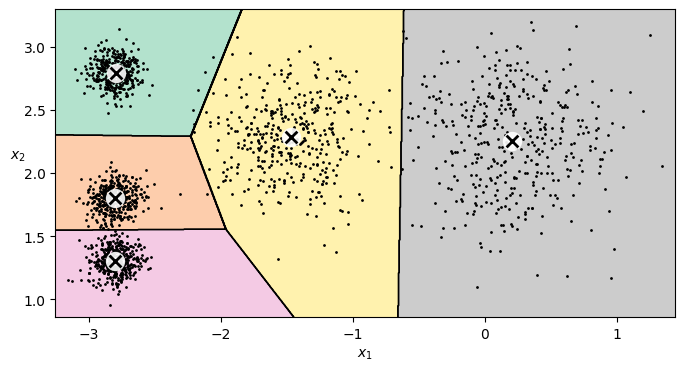

In [29]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(k_means, X)

### Inertia

You can access the inertia of a model via the `inertia_` attribute.

In [30]:
k_means.inertia_

211.59853725816836

In [31]:
k_means_rnd_init1.inertia_

219.58201503602288

In [32]:
k_means_rnd_init2.inertia_

239.1922640341045

As you can easily verify, inertia is the sum of all squared distance between each training instances and its closest centroids.

In [33]:
X_distance = k_means.transform(X)
(X_distance[np.arange(len(X_distance)), k_means.labels_] ** 2).sum()

211.5985372581687

The `score()` method returns the negative inertia. Why negative? Because a predictor's `score()` method must always respect the "*greater is better*" rule.

In [34]:
k_means.score(X)

-211.59853725816836

### Multiple Initializations

One approach to solve this variability issue is to simply run the K-means algorithm several times with different random initializations, and select the solution that minimizes the inertia.

When you set the `n_init` hyperparameter, Scikit-learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-learn sets `n_init=10`.

In [35]:
k_means_rnd_10_init = KMeans(n_clusters=5, init="random", n_init=10, random_state=42)
k_means_rnd_10_init.fit(X)

KMeans(init='random', n_clusters=5, n_init=10, random_state=42)

As you can see, we end up with the initial model, which is certainly the optimal K-means solution (at least in term of inertia, and assuming $k = 5$).

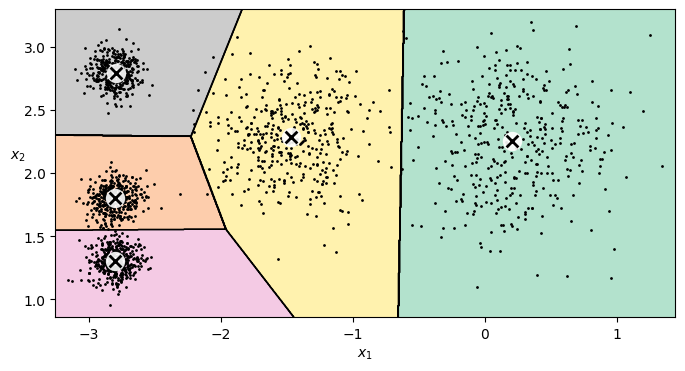

In [36]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(k_means_rnd_10_init, X)

In [37]:
k_means_rnd_10_init.inertia_

211.5985372581684

In Scikit-learn, we actually uses K-Means++ as the default algorithm for centroids initialization. If you want to specifically set to K-Means, set `init="k-means++"`.

### Accelerated K-Means and Mini-batch K-means

If you want to use accelerated K-means, set `algorithm="elkan"`. For regular KMeans, use `algorithm="llyod"`. More explanation about the Elkan's algorithm can be seen in note.md.

Scikit-learn also implements a variant of the K-means that supports mini-batches.

In [38]:
from sklearn.cluster import MiniBatchKMeans

mini_batch_k_means = MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)
mini_batch_k_means.fit(X)

MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)

In [39]:
mini_batch_k_means.inertia_

211.65899374574315

**Using `MiniBatchKMeans` along with `memmap`** (not in the book)

If the dataset does not fit in the memory, the simplest option is to use the `memmap` class, like we did for incremental PCA in the previous chapter. First let's load MNIST.

In [40]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False, parser="auto")

Let's split the dataset.

In [41]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

Now, let's write the training set to a `memmap`.

In [42]:
X_memmap = np.memmap(
    filename="my_mnist.mmap", dtype="float32", mode="write", shape=X_train.shape
)
X_memmap[:] = X_train
X_memmap.flush()

In [43]:
from sklearn.cluster import MiniBatchKMeans

mini_batch_k_means = MiniBatchKMeans(
    n_clusters=10, batch_size=10, n_init=3, random_state=42
)
mini_batch_k_means.fit(X_memmap)

MiniBatchKMeans(batch_size=10, n_clusters=10, n_init=3, random_state=42)

Here, I plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means. 

In [44]:
from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    k_means_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    mini_batch_k_means_ = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)
    print(f"\r{k}/{max_k}", end="")  # \r returns the start of the line
    times[k - 1, 0] = timeit("k_means_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("mini_batch_k_means_.fit(X)", number=10, globals=globals())

    inertias[k - 1, 0] = k_means_.inertia_
    inertias[k - 1, 1] = mini_batch_k_means_.inertia_

100/100

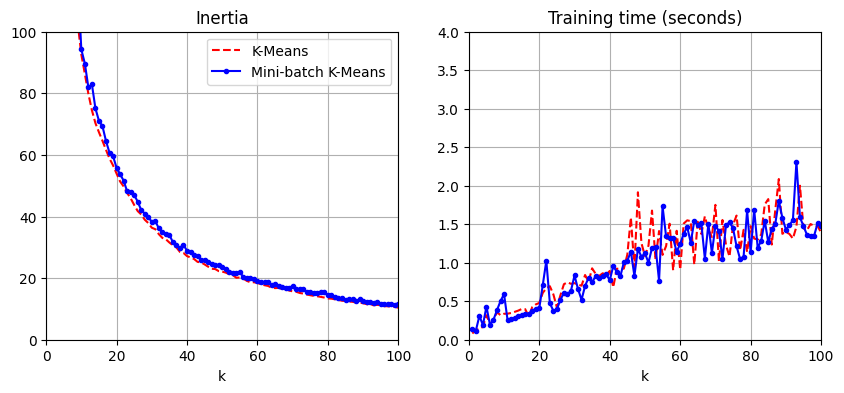

In [45]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.legend()
plt.xlabel("k")
plt.title("Inertia")
plt.grid()
plt.axis([0, max_k, 0, 100])

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-")
plt.xlabel("k")
plt.title("Training time (seconds)")
plt.grid()
plt.axis([0, max_k, 0, 4])

plt.show()

### Finding the optimal number of clusters

What if the number of cluster was set to a number lower or greater than 5?

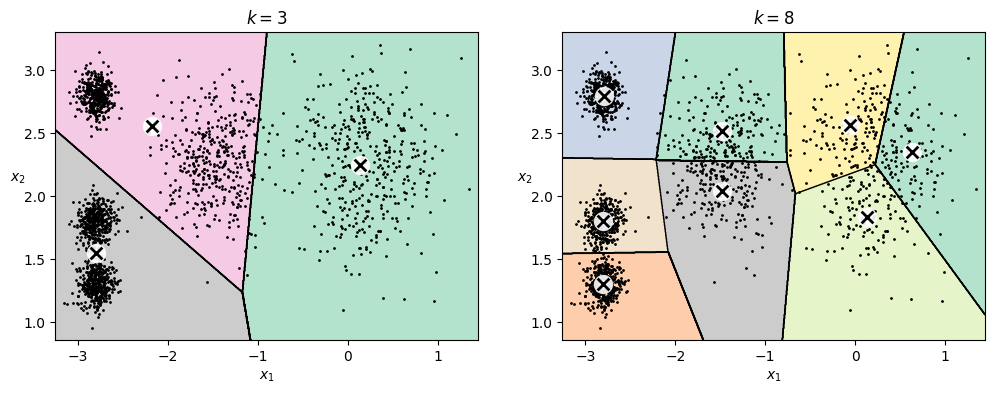

In [46]:
k_means_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
k_means_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)

plot_clusterer_comparison(k_means_k3, k_means_k8, X, "$k=3$", "$k=8$")
plt.show()

Well, these 2 models don't work so great. What about their inertias?

In [47]:
k_means_k3.inertia_

653.2167190021552

In [48]:
k_means_k8.inertia_

119.22484592677124

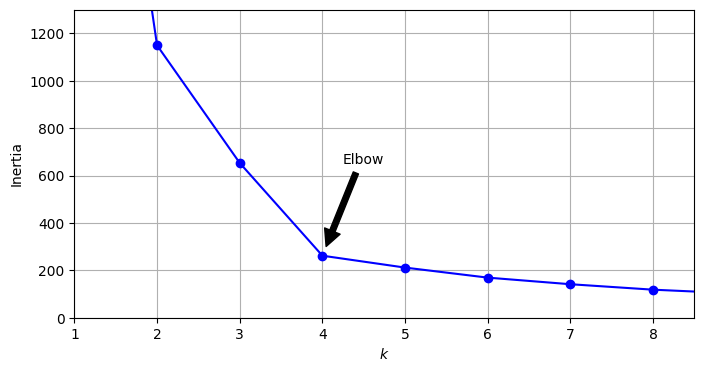

In [49]:
k_means_per_k = [
    KMeans(n_clusters=k, n_init=10, random_state=1).fit(X) for k in range(1, 10)
]
inertias = [model.inertia_ for model in k_means_per_k]

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate(
    "",
    xy=(4, inertias[3]),
    xytext=(4.45, 650),
    arrowprops=dict(facecolor="black", shrink=0.1),
)
plt.text(4.5, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
plt.show()

Let's plot the silhouette as a function of *k*.

In [50]:
from sklearn.metrics import silhouette_score

silhouette_score(X, k_means.labels_)

0.655517642572828

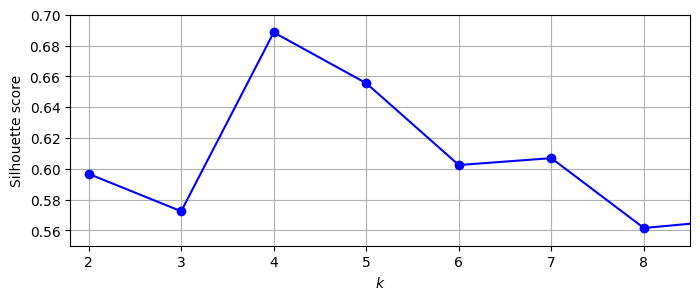

In [51]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in k_means_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid()
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

There's even a more informative visualization way: We plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a *silhouette diagram*.

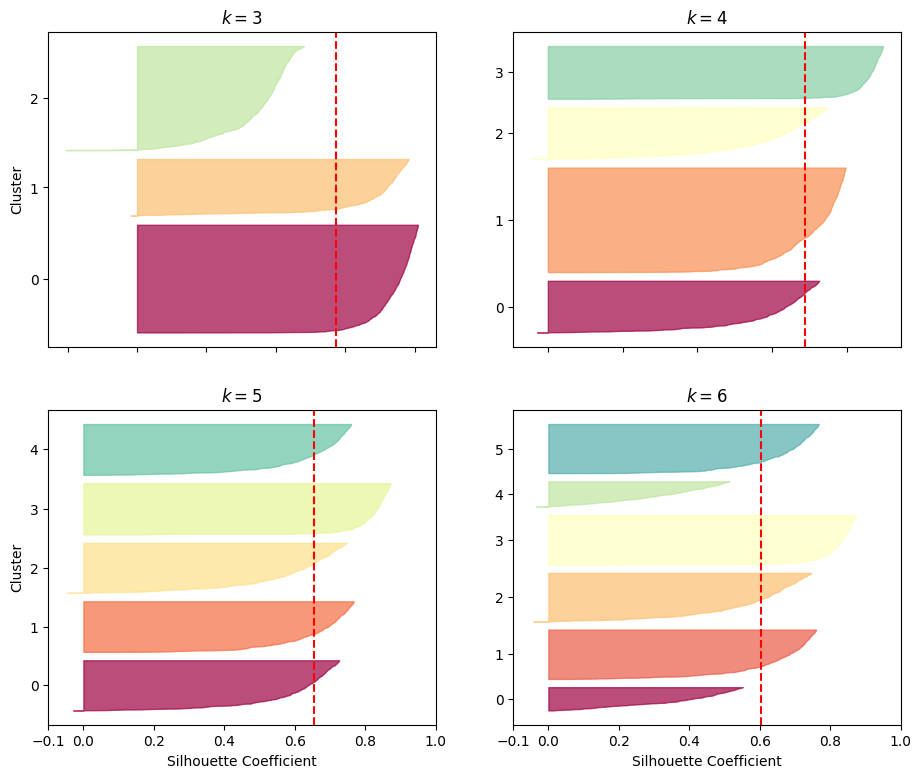

In [52]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedFormatter, FixedLocator

plt.figure(figsize=(11, 9))

for k in [3, 4, 5, 6]:
    plt.subplot(2, 2, k - 2)

    y_predict = k_means_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_predict)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coefficients: np.ndarray = silhouette_coefficients[y_predict == i]
        coefficients.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(
            np.arange(pos, pos + len(coefficients)),
            0,
            coefficients,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ticks.append(pos + len(coefficients) // 2)
        pos += len(coefficients) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in [3, 5]:
        plt.ylabel("Cluster")
    if k in [5, 6]:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

## Limits of K-Means

Here we create a more difficult dataset, with elongated blobs and and varying densities, and shows how K-Means struggles to cluster it properly.

In [60]:
X1, y1 = make_blobs(n_samples=1000, centers=[(4, -4), (0, 0)], random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [62]:
k_means_good = KMeans(
    n_clusters=3, init=np.array([[-2, 2], [0, 0], [4, 0]]), n_init=1, random_state=42
)
k_means_bad = KMeans(n_clusters=3, n_init=10, random_state=42)
k_means_good.fit(X)
k_means_bad.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

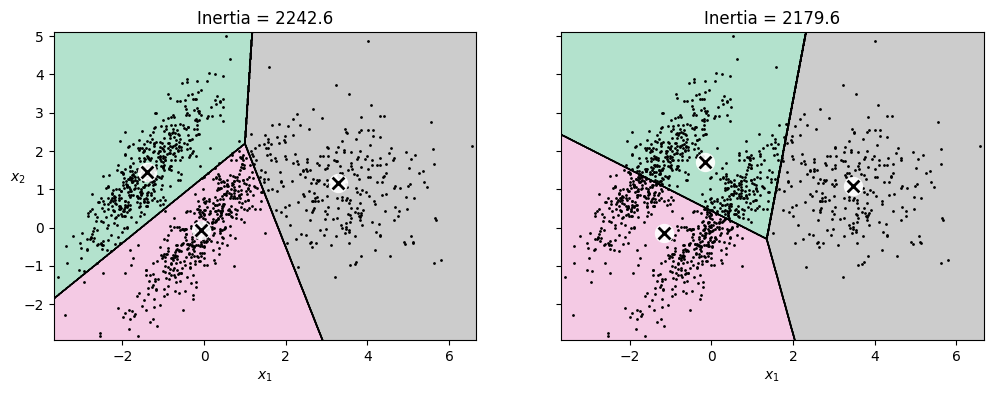

In [65]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_decision_boundaries(k_means_good, X)
plt.title(f"Inertia = {k_means_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(k_means_bad, X, show_ylabels=False)
plt.title(f"Inertia = {k_means_bad.inertia_:.1f}")

plt.show()

## Using Clustering for Image Segmentation

Download the ladybug image:

In [67]:
import urllib.request
from pathlib import Path

url_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
filepath = Path() / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{url_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

In [69]:
import PIL

image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

We reshape the array to get a long list of RGB colors, then cluster theses colors using k-means with eight clusters. It creates a `segmented_img` array containing the nearest cluster for each pixel (i.e. the mean color of each pixel's cluster), and lastly it reshapes this array to the original image shape. The third line uses advanced NumPy indexing: For example, if the first 10 labels in `k_means.labels_` is equal to 1, then the first 10 colors in `segmented_img` are equal to `k_means.cluster_centers_[1]`.

In [71]:
X = image.reshape(-1, 3)
k_means = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
segmented_img = k_means.cluster_centers_[k_means.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [78]:
segmented_imgs = []
n_colors = [10, 8, 6, 4, 2]
for n_cluster in n_colors:
    k_means_ = KMeans(n_clusters=n_cluster, n_init=10, random_state=42).fit(X)
    segmented_img = k_means_.cluster_centers_[k_means_.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

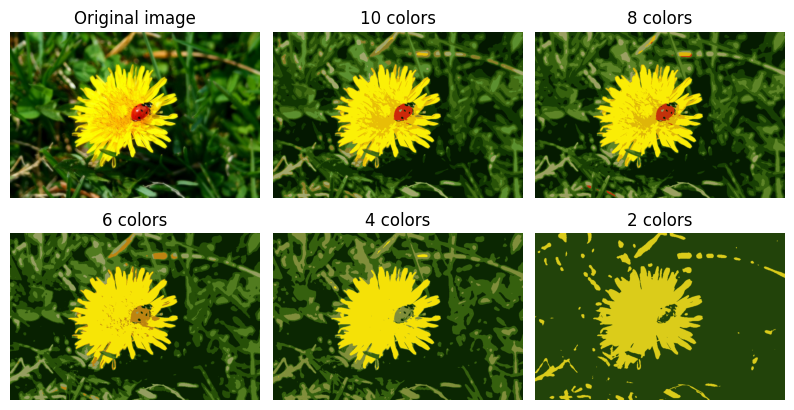

In [80]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis("off")

for idx, n_cluster in enumerate(n_colors):
    plt.subplot(2, 3, idx + 2)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_cluster} colors")
    plt.axis("off")

plt.show()